In [1]:
from d2l import tensorflow as d2l
import tensorflow as tf

import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config Completer.use_jedi = False

features = np.array([[0,0],[0,1],[1,0],[1,1]], "float32")
labels   = np.array([0,1,1,0], "float32")

In [2]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    index = list(range(num_examples))
    # Las observaciones se leen en orden aleatorio
    random.shuffle(index)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(index[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [3]:
batch_size = 4

train_iter = data_iter(batch_size, features, labels)
test_iter  = data_iter(batch_size, features, labels)

for X, y in train_iter:
    print(X, '\n\n', y)

tf.Tensor(
[[0. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32) 

 tf.Tensor([1. 0. 1. 0.], shape=(4,), dtype=float32)


In [4]:
def train_procedure(net, features, labels, batch_size, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.25],
                        legend=['train loss', 'train acc', 'test acc'], 
                        figsize = [12, 4])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, 
                                            data_iter(batch_size, features, labels), 
                                            loss, 
                                            updater)
        test_acc = d2l.evaluate_accuracy(net, 
                                         data_iter(batch_size, features, labels))
        animator.add(epoch + 1, train_metrics)
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [5]:
lr = 1.0
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)

In [6]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, 
                          activation='relu', 
                          kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 100)),
    tf.keras.layers.Dense(2, 
                          kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 200))])

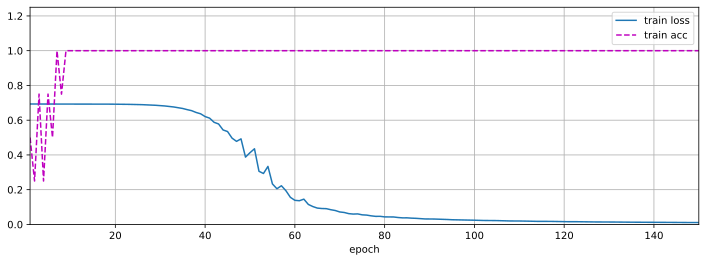

In [7]:
num_epochs = 150
train_procedure(net, features, labels, batch_size, loss, num_epochs, trainer)

In [8]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

def relu(X):
    return tf.math.maximum(X, 0)

In [9]:
n_grid = 100
X1, X2 = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))
X_ = np.hstack([X1.reshape(-1,1), X2.reshape(-1,1)]).reshape(-1,2)
Z = net(X_)

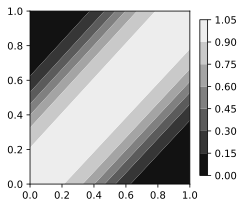

In [10]:
fig, ax = plt.subplots(1,1, figsize = [3.5, 3])

cs = ax.contourf(X1, X2, softmax(Z)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
fig.colorbar(cs, ax=ax, shrink=0.9)
plt.tight_layout()

In [11]:
W1 = net.trainable_variables[0].numpy()
b1 = net.trainable_variables[1].numpy()

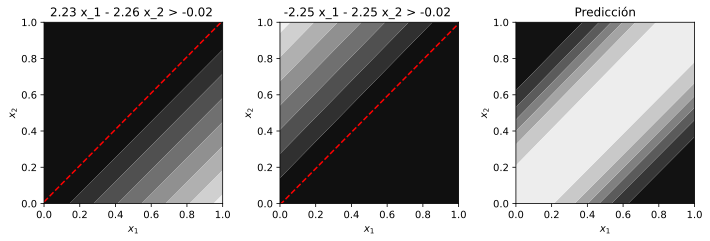

In [12]:
fig, axes = plt.subplots(1,3, figsize = [10, 3.5])

H = relu(X_.dot(net.trainable_variables[0].numpy()) + net.trainable_variables[1].numpy()).numpy()

axes[0].contourf(X1, X2, H[:,0].reshape(n_grid, -1), cmap = 'gray')
axes[0].set_title("%2.2f x_1 - %2.2f x_2 > %2.2f "%(W1[0][0],abs(W1[0][1]), b1[0]) )
axes[0].plot(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid) + b1[0]/W1[0][1], color = 'red', linestyle = 'dashed')

axes[1].contourf(X1, X2, H[:,1].reshape(n_grid, -1), cmap = 'gray')
axes[1].set_title("%2.2f x_1 - %2.2f x_2 > %2.2f "%(W1[1][0],abs(W1[1][1]), b1[1]) )
axes[1].plot(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid) + b1[1]/W1[1][1], color = 'red', linestyle = 'dashed')

axes[-1].contourf(X1, X2, softmax(Z)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
axes[-1].set_title("Predicción");

for ax in axes:
    ax.set_ylim(0,1); 
    ax.set_xlim(0,1); 
    ax.set_ylabel("$x_2$")
    ax.set_xlabel("$x_1$")
    
    
fig.tight_layout()

In [13]:
W2 = net.trainable_variables[2].numpy()
b2 =net.trainable_variables[3].numpy()

H1, H2 = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))
H_ = np.hstack([H1.reshape(-1,1), H2.reshape(-1,1)]).reshape(-1,2)

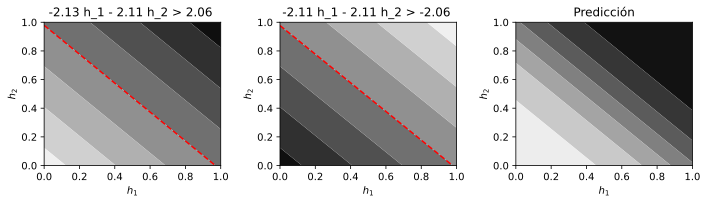

In [14]:
fig, axes = plt.subplots(1,3, figsize = [10, 3])

OH = H_.dot(net.trainable_variables[2].numpy()) + net.trainable_variables[3].numpy()

axes[0].contourf(X1, X2, OH[:,0].reshape(n_grid, -1), cmap = 'gray')
axes[0].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[0][0],abs(W2[0][1]), b2[0]) )
axes[0].set_xlabel("$h_1$"); axes[0].set_ylabel("$h_2$")
axes[0].plot(np.linspace(0,1,n_grid), W2[0][0]/W2[0][1] * np.linspace(0,1,n_grid) + b2[0]/W2[0][1], color = 'red', linestyle = 'dashed')

axes[1].contourf(X1, X2, OH[:,1].reshape(n_grid, -1), cmap = 'gray')
axes[1].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[1][0],abs(W2[1][1]), b2[1]) )
axes[1].set_xlabel("$h_1$"); axes[1].set_ylabel("$h_2$");
axes[1].plot(np.linspace(0,1,n_grid), W2[1][0]/W2[1][1] * np.linspace(0,1,n_grid) - b2[1]/W2[1][1], color = 'red', linestyle = 'dashed')

axes[-1].contourf(X1, X2, softmax(OH)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
axes[-1].set_title("Predicción");
axes[-1].set_xlabel("$h_1$"); axes[-1].set_ylabel("$h_2$"); 

for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

fig.tight_layout()

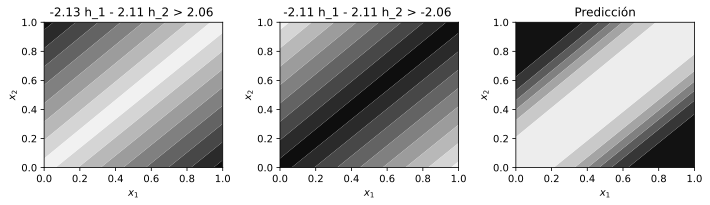

In [15]:
fig, axes = plt.subplots(1,3, figsize = [10, 3])

O = H.dot(net.trainable_variables[2].numpy()) + net.trainable_variables[3].numpy()

axes[0].contourf(X1, X2, O[:,0].reshape(n_grid, -1), cmap = 'gray')
axes[0].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[0][0],abs(W2[0][1]), b2[0]) )
axes[0].set_xlabel("$x_1$"); axes[0].set_ylabel("$x_2$")

axes[1].contourf(X1, X2, O[:,1].reshape(n_grid, -1), cmap = 'gray')
axes[1].set_title("%2.2f h_1 - %2.2f h_2 > %2.2f "%(W2[1][0],abs(W2[1][1]), b2[1]) )
axes[1].set_xlabel("$x_1$"); axes[1].set_ylabel("$x_2$");

axes[-1].contourf(X1, X2, softmax(Z)[:,0].numpy().reshape(n_grid, -1), cmap = 'gray')
axes[-1].set_title("Predicción");
axes[-1].set_xlabel("$x_1$"); axes[-1].set_ylabel("$x_2$"); 

for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

fig.tight_layout()

# Solucion fácil y aburrida :P 

In [16]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [17]:
net.compile(loss='binary_crossentropy',
            optimizer='sgd', 
            metrics=['binary_accuracy'])

In [18]:
net.fit(features, labels, verbose = 0, epochs=200)